In [2]:
import sys
sys.path.append('../')
import importlib

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import seaborn as sbn
from contextlib import redirect_stdout
import json
import ast

import DataGeneration as dgen
import Classifier as clf
import TuningCurves as tun

In [3]:
#size = "big"
size = "small"
#size = "special"

with open(size+'_dataset.json', 'r') as json_file:
    data = json.load(json_file)

frates_actor = np.array(data["frates_actor"])
frates_critic = np.array(data["frates_critic"])
final_actions = np.array(data["final_actions"])
right_values = np.array(data["right_values"])
left_values = np.array(data["left_values"])
overall_values = np.array(data["overall_values"])
global_values = np.array(data["global_values"])
stimuli = np.array(data["stimuli"])
timeav_values = np.array(data["timeav_values"])

In [32]:
net = {"X" : frates_actor, "network" : "actor"}
#net = {"X" : frates_critic, "network" : "critic"}

label = {"Y" : final_actions, "label" : "actions"}
#label = {"Y" : right_values, "label" : "right_values"}
#label = {"Y" : left_values, "label" : "left_values"}
#label = {"Y" : global_values, "label" : "global_values"}

#model = {"model" : 'perceptron', "param" : 0}
model = {"model" : 'perceptronL1', "param" : 0.01}
#model = {"model" : 'svm', "param" : 0.00001}

average over 50 epochs of test scores: 0.50
average over 50 epochs of test random scores: 0.52
average over 50 epochs of test scores: 0.48
average over 50 epochs of test random scores: 0.51
average over 50 epochs of test scores: 0.64
average over 50 epochs of test random scores: 0.49
average over 50 epochs of test scores: 0.73
average over 50 epochs of test random scores: 0.50
average over 50 epochs of test scores: 0.83
average over 50 epochs of test random scores: 0.52
average over 50 epochs of test scores: 0.85
average over 50 epochs of test random scores: 0.50
average over 50 epochs of test scores: 0.86
average over 50 epochs of test random scores: 0.51
average over 50 epochs of test scores: 0.86
average over 50 epochs of test random scores: 0.50
average over 50 epochs of test scores: 0.87
average over 50 epochs of test random scores: 0.50
average over 50 epochs of test scores: 0.85
average over 50 epochs of test random scores: 0.50
average over 50 epochs of test scores: 0.86
averag

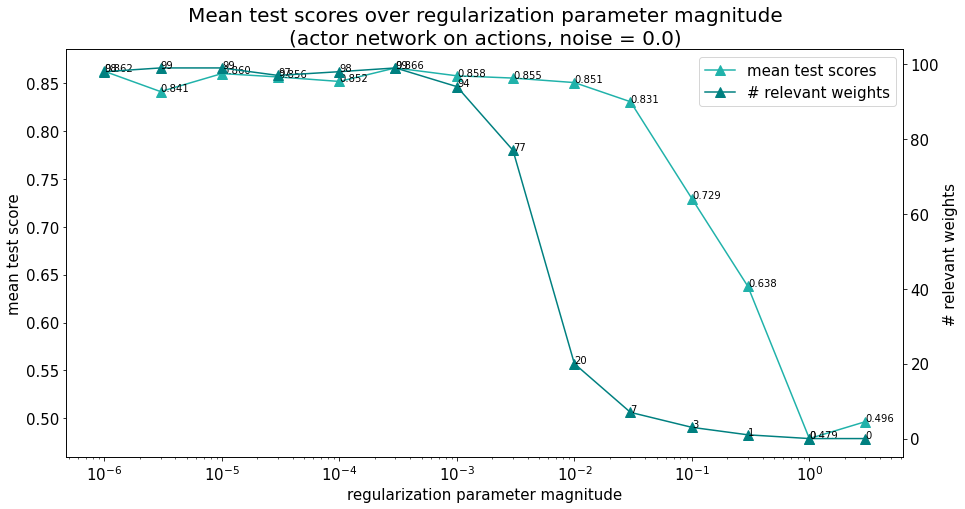

In [33]:
importlib.reload(clf)

noise_mag = np.array([0])
#param_mag = np.array([1e-10])
param_mag = np.array([3, 1, 3e-1, 1e-1, 3e-2, 1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6])
#param_mag = np.array([1e-4, 5e-5, 1e-5, 5e-6, 1e-6])

clf.regularization_intensity(X=net["X"], Y=label["Y"], model=model["model"], param_mag=param_mag,\
                             network=net["network"], label=label["label"], noise_mag=noise_mag, size=size)

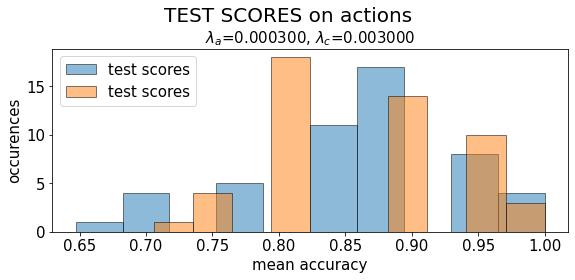

In [41]:
importlib.reload(clf)

param_mag = np.array([3e-4, 3e-3])

clf.actor_vs_critic(frates_actor, frates_critic, Y=label["Y"], model=model["model"],
                    param_mag=param_mag, label=label["label"], noise_mag=0, size=size)


----------
training score: 0.688
test score: 0.588 
----------


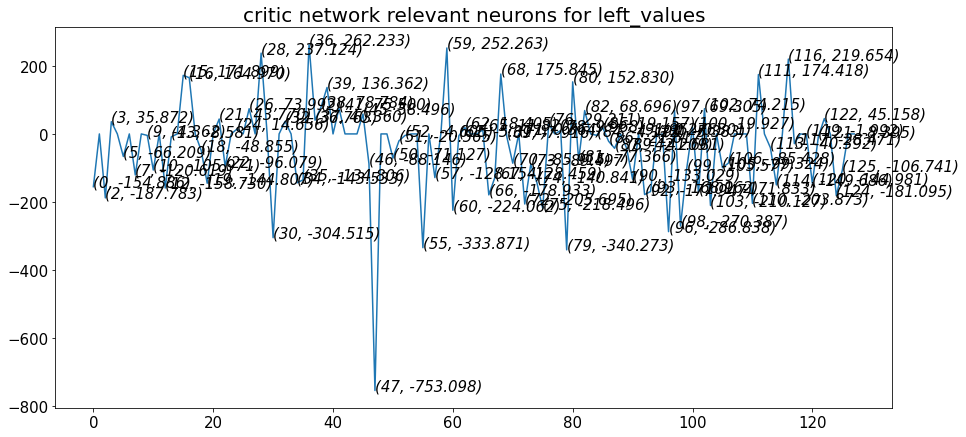

In [18]:
importlib.reload(clf)

clf.rel_neurons(X=net["X"], Y=label["Y"], model=model["model"], C=1e-2,\
               network=net["network"], label=label["label"], noise_mag=0, size=size)

In [23]:
if net["network"] == "actor":
    with open("clf_data_"+size+"/"+label["label"]+"/relevant_neurons_actor.json", 'r') as json_file:
        file_content = json.load(json_file)
else:
    with open("clf_data_"+size+"/"+label["label"]+"/relevant_neurons_critic.json", 'r') as json_file:
        file_content = json.load(json_file)

relevant_neurons = np.array(file_content["relevant_neurons"])
relevant_weights = np.array(file_content["relevant_weights"])
random_neurons = np.array(file_content["random_neurons"])
random_weights = np.array(file_content["random_weights"])
print(relevant_neurons)
#print(relevant_weights)
print(random_neurons)
#print(random_weights)

[ 47  55  59  28  96  30  36  79  60 114]
[ 65  66  26  44  25  95 126  65 108  16]


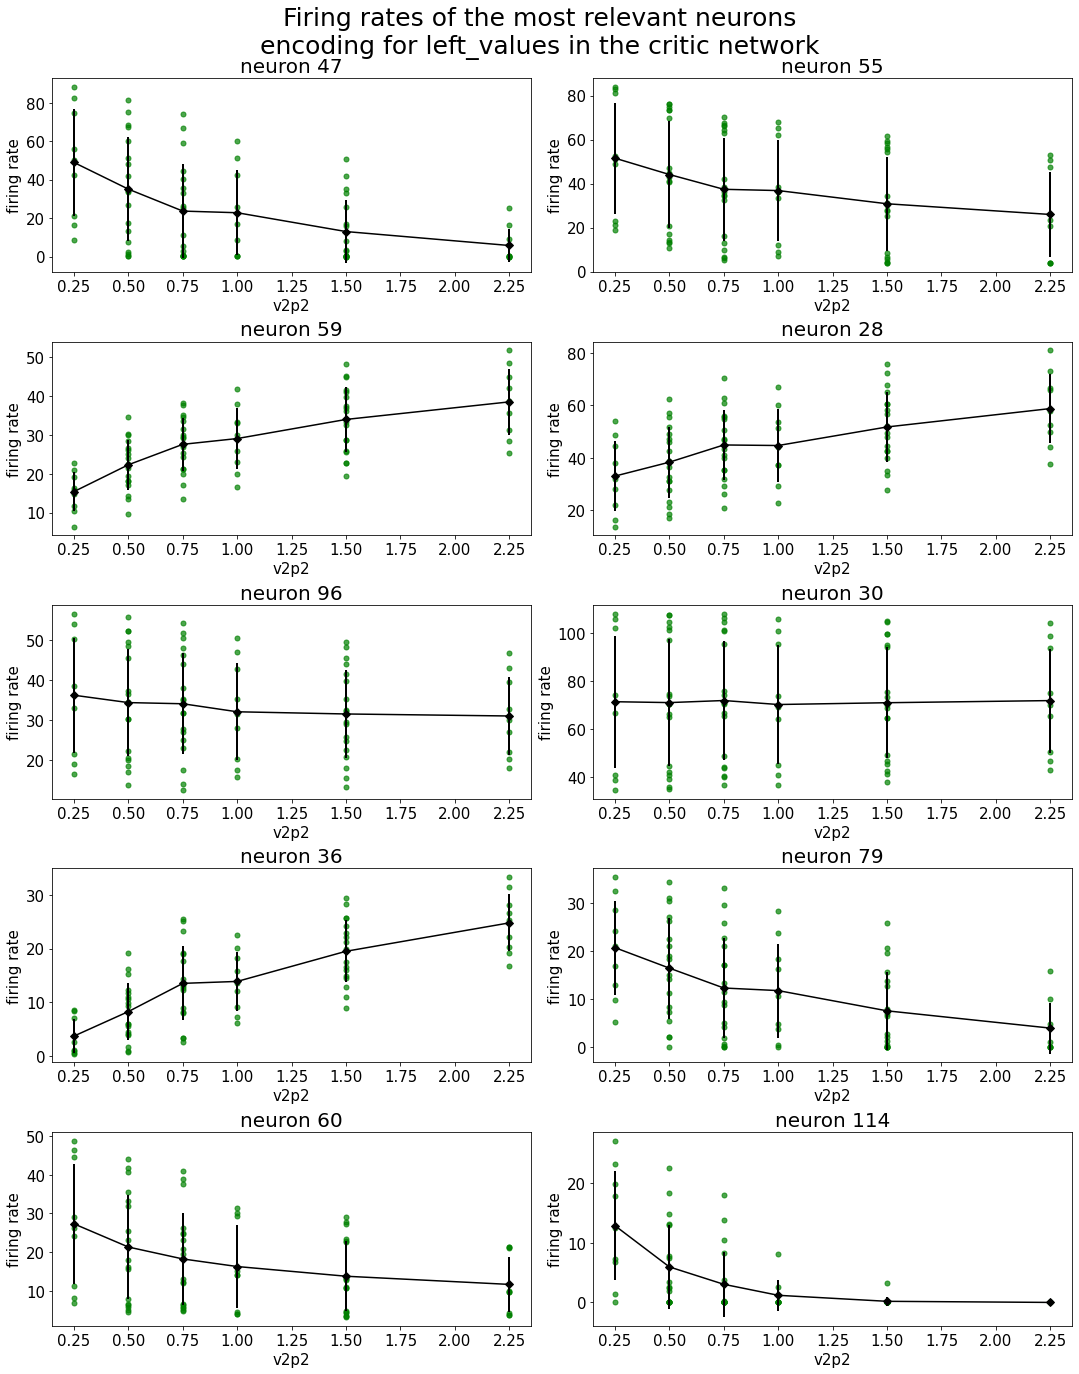

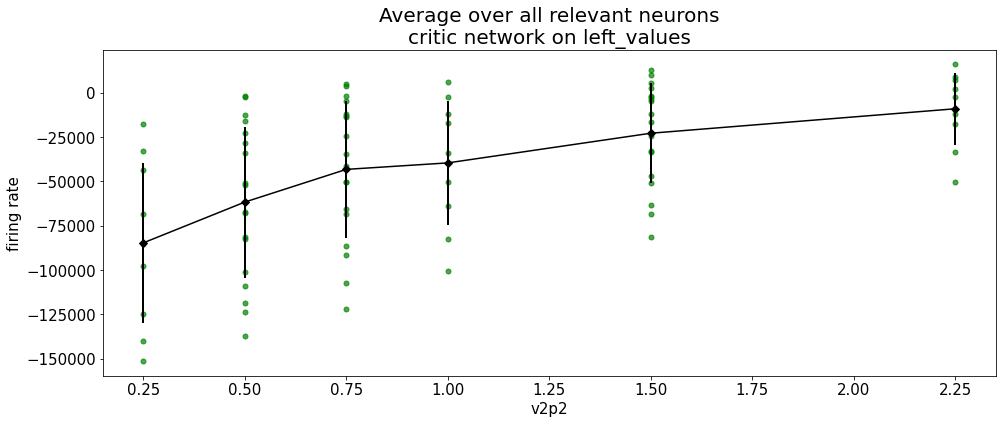

In [24]:
importlib.reload(tun)

#relevant_neurons = np.arange(0,128)
#relevant_weights = np.ones(128)

tun.tuning_curves(relevant_neurons, relevant_weights, net["X"], stimuli, net["network"], label["label"])

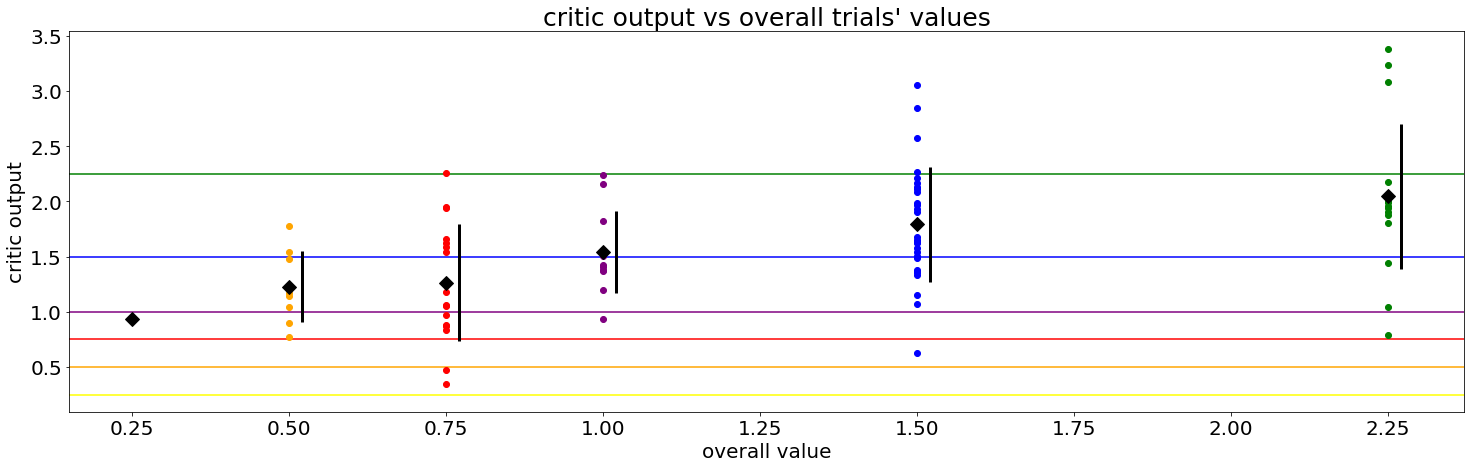

In [25]:
importlib.reload(tun)

tun.critic_tuning_curves(timeav_values, overall_values)

In [22]:
importlib.reload(tun)

tun.neurons_population(net["X"], label["Y"], net["network"], label["label"])

In [4]:
import json
import numpy as np
with open('neurons_population.json', 'r') as json_file:
    data = json.load(json_file)

averages = np.array(data["averages"])
stds = np.array(data["stds"])
dcs = np.array(data["dcs"])

In [5]:
averages

array([[1.00025660e+01, 1.80389292e+01],
       [0.00000000e+00, 0.00000000e+00],
       [3.61812560e+01, 5.35109477e+01],
       [2.92673436e+01, 4.28335372e+01],
       [0.00000000e+00, 0.00000000e+00],
       [7.74284245e+01, 7.52068941e+01],
       [0.00000000e+00, 0.00000000e+00],
       [3.00222104e+01, 4.33465891e+01],
       [0.00000000e+00, 0.00000000e+00],
       [2.63625610e+00, 4.61509736e-01],
       [2.01448057e+01, 1.63868709e+01],
       [0.00000000e+00, 0.00000000e+00],
       [4.72489235e+01, 5.54343454e+01],
       [2.47120666e+01, 2.27700538e+01],
       [0.00000000e+00, 0.00000000e+00],
       [5.56016451e+01, 5.98921176e+01],
       [6.38078622e+01, 6.60652304e+01],
       [0.00000000e+00, 0.00000000e+00],
       [5.19507386e+00, 1.11012083e+01],
       [2.94009119e+00, 7.63017178e+00],
       [0.00000000e+00, 0.00000000e+00],
       [5.14308354e+01, 5.32159864e+01],
       [5.13286837e+01, 5.50978559e+01],
       [1.67205675e-01, 1.09276095e-01],
       [4.769672